## Import and install libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Toronto map with all neighborhoods

Here we give it a try to visualize all neighborhoods in Toronto area

In [3]:
# Load the dataframe first
df = pd.read_csv('toronto_neighborhoods_coords.csv', index_col = 0)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [5]:
# create map of Toronto using latitude and longitude values
latitude, longitude = 43.6570304,-79.6017288
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Neighborhoods that only contain 'Toronto'

There are two approaches for further analysis:
* Continue using all neighborhoods for further analysis
* Use only the neighborhoods containing 'Toronto'

There are advantages and disadvantages to both. All neighborhoods provides sufficient data for a good analysis, however further exploration showed that the optimum number of clusters will exceed 10, making those hard to summarize and describe.

Contrary to this, there are only seven neighborhoods containing 'Toronto'. Clusterization will likely result in some clusters containing only a single neighborhood. 

Further work uses the latter option. 

In [6]:
df_toronto = df[df.Neighborhood.str.contains('Toronto')]
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
30,M3K,North York,"CFB Toronto,Downsview East",43.737473,-79.464763
40,M4J,East York,East Toronto,43.685347,-79.338106
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
59,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752
60,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576
66,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049
88,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321


### All neighborhoods in Toronto
As mentioned above, the following code (commented out) will use *all* neighborhoods for further analysis. Note, that this is NOT used further. 

In [ ]:
#df_toronto = df

## Extract venues in each Borough

The next step retrieved venues for each neighborhood. Radius of 500 meters was selected as the optimal value for the pull.

In [7]:
# Pull API keys from the file
with open('foursquare_keys.txt','r') as f:
    CLIENT_ID, CLIENT_SECRET = [l.strip() for l in f.readlines()]

VERSION = '20180605' # Foursquare API version

In [8]:
# Test run on the first neighborhood
borough, neighborhood_latitude, neighborhood_longitude = df_toronto.iloc[0,[1,3,4]].tolist()
print('Borough: %s, Lat: %.2f, Lon: %.2f'%(borough, neighborhood_latitude, neighborhood_longitude))

Borough: North York, Lat: 43.74, Lon: -79.46


In [9]:
# Define an auxiliary function to pull the category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
# Pull up to 100 venues within 500 meters of the borough
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Toronto Downsview Airport (YZD),Airport,43.738883,-79.470111
1,Ttc Bus #120 - Plewes Rd,Bus Stop,43.734898,-79.464221
2,Ancaster Park Playground,Playground,43.734478,-79.465673
3,Ancaster Park,Park,43.733724,-79.465528


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
# Search for the venues within 500 m radius
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'],
                                 radius = 500)
toronto_venues.head()

CFB Toronto,Downsview East
East Toronto
North Toronto West
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Harbord,University of Toronto
Humber Bay Shores,Mimico South,New Toronto


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"CFB Toronto,Downsview East",43.737473,-79.464763,Toronto Downsview Airport (YZD),43.738883,-79.470111,Airport
1,"CFB Toronto,Downsview East",43.737473,-79.464763,Ttc Bus #120 - Plewes Rd,43.734898,-79.464221,Bus Stop
2,"CFB Toronto,Downsview East",43.737473,-79.464763,Ancaster Park Playground,43.734478,-79.465673,Playground
3,"CFB Toronto,Downsview East",43.737473,-79.464763,Ancaster Park,43.733724,-79.465528,Park
4,East Toronto,43.685347,-79.338106,The Path,43.683923,-79.335007,Park


In [13]:
# See how many venues by neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"CFB Toronto,Downsview East",4,4,4,4,4,4
"Design Exchange,Toronto Dominion Centre",100,100,100,100,100,100
East Toronto,2,2,2,2,2,2
"Harbord,University of Toronto",34,34,34,34,34,34
"Harbourfront East,Toronto Islands,Union Station",100,100,100,100,100,100
"Humber Bay Shores,Mimico South,New Toronto",15,15,15,15,15,15
North Toronto West,21,21,21,21,21,21


Unfortunately, some neighborhoods have only few venues. For instance, East Toronto -- 2 venues, CFB Toronto, Downsview East -- 4. 

This is important for further analysis, because any venues beyond two for East Toronto cannot be trusted. One approach to mitigate the problem is to increase the radius above. Unfortunately, it may bring venues from adjacent neighborhoods and skew the analysis. 

In [14]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 102 unique categories.


## Analysis of the neighborhoods

In [15]:
# convert them to one-hot encodings

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,American Restaurant,Aquarium,Art Gallery,Asian Restaurant,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Event Space,Fast Food Restaurant,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Travel,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lake,Liquor Store,Lounge,Mexican Restaurant,Monument / Landmark,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Poutine Place,Pub,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,East Toronto,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# check the shape of the dataframe
toronto_onehot.shape

(276, 102)

In [18]:
# group by neighborhoods and see averages of how many venues of each category are there
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,American Restaurant,Aquarium,Art Gallery,Asian Restaurant,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Event Space,Fast Food Restaurant,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Travel,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lake,Liquor Store,Lounge,Mexican Restaurant,Monument / Landmark,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Poutine Place,Pub,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar
0,"CFB Toronto,Downsview East",0.0,0.25,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.25,0.00,0.0,0.00,0.25,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
1,"Design Exchange,Toronto Dominion Centre",0.0,0.00,0.04,0.00,0.01,0.01,0.0,0.010000,0.00,0.020000,0.00,0.01,0.020000,0.000000,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.080000,0.000000,0.0,0.140000,0.000000,0.000000,0.000000,0.01,0.0,0.00,0.03,0.0,0.0,0.00,0.01,0.0,0.01,0.010000,0.01,0.0,0.03,0.01,0.01,0.01,0.0,0.030000,0.01,0.00,0.08,0.01,0.01,0.00,0.00,0.030000,0.020000,0.000000,0.00,0.0,0.01,0.0,0.00,0.01,0.00,0.01,0.000000,0.010000,0.01,0.00,0.00,0.0,0.01,0.00,0.00,0.000000,0.010000,0.0,0.040000,0.01,0.0,0.010000,0.00,0.02,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.00,0.000000,0.01,0.01,0.010000,0.01,0.00,0.000000,0.01
2,East Toronto,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.5,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.50,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
3,"Harbord,University of Toronto",0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.058824,0.00,0.058824,0.00,0.00,0.029412,0.029412,0.00,0.058824,0.00,0.00,0.00,0.00,0.00,0.117647,0.029412,0.0,0.058824,0.029412,0.029412,0.029412,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.029412,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.058824,0.029412,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.029412,0.029412,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.029412,0.029412,0.0,0.058824,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00
4,"Harbourfront East,Toronto Islands,Union Station",0.0,0.00,0.01,0.05,0.01,0.00,0.0,0.030000,0.01,0.020000,0.01,0.01,0.010000,0.000000,0.01,0.00000

In [19]:
toronto_grouped.shape

(7, 102)

We can only use the max two venues per neighborhood, because of East Toronto with only two venues.

In [37]:
# Print the top 2 venues per each neighborhood
num_top_venues = 2
for n in toronto_grouped['Neighborhood']:
    print("------- %s -------"%n)
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == n].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------- CFB Toronto,Downsview East -------
        venue  freq
0     Airport  0.25
1  Playground  0.25


------- Design Exchange,Toronto Dominion Centre -------
         venue  freq
0  Coffee Shop  0.14
1        Hotel  0.08


------- East Toronto -------
               venue  freq
0  Convenience Store   0.5
1               Park   0.5


------- Harbord,University of Toronto -------
         venue  freq
0         Café  0.12
1  Coffee Shop  0.06


------- Harbourfront East,Toronto Islands,Union Station -------
         venue  freq
0  Coffee Shop  0.14
1        Hotel  0.05


------- Humber Bay Shores,Mimico South,New Toronto -------
        venue  freq
0        Café  0.13
1  Restaurant  0.07


------- North Toronto West -------
                 venue  freq
0  Sporting Goods Shop  0.14
1          Coffee Shop  0.10




In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
0,"CFB Toronto,Downsview East",Playground,Airport
1,"Design Exchange,Toronto Dominion Centre",Coffee Shop,Hotel
2,East Toronto,Convenience Store,Park
3,"Harbord,University of Toronto",Café,Bakery
4,"Harbourfront East,Toronto Islands,Union Station",Coffee Shop,Aquarium
5,"Humber Bay Shores,Mimico South,New Toronto",Café,Pharmacy
6,North Toronto West,Sporting Goods Shop,Coffee Shop


## Assign neighborhoods to clusters

First -- let us take a random shot at the number of clusters

In [40]:
# set number of clusters at random first
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 0, 1, 0, 0, 0, 3], dtype=int32)

### Determine the best number of clusters

This is done using the `elbow` method. In this method KMeans runs for 2,3,4,...,7 clusters and the average distance of the points to their clusters is calculated. The average distances are visualized and the optimum cluster number is where the "elbow" of the plot is. 

In [41]:
# Calculate the average distances of each point to its cluster center
# for the number of clusters from 2 to 7
max_k = 8
squared_distance = np.zeros(max_k)
for k in range(2,max_k):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(toronto_grouped_clustering)
    squared_distance[k] = kmeans.inertia_

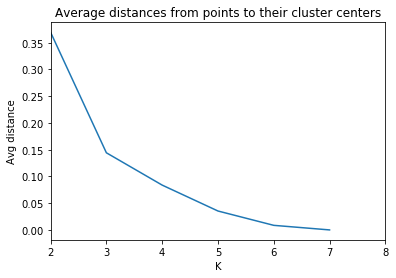

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlabel('K')
plt.ylabel('Avg distance')
plt.title('Average distances from points to their cluster centers')
plt.xlim([2,max_k])
plt.show()

The "elbow" of the curve is clearly at 3, so choose it as the optimum number of clusters:

In [44]:
# Based on picture above, the optimum number of clusters is around 3
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(toronto_grouped_clustering)

In [45]:
toronto_grouped_clustering.head()

,Yoga Studio,Airport,American Restaurant,Aquarium,Art Gallery,Asian Restaurant,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Event Space,Fast Food Restaurant,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Travel,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lake,Liquor Store,Lounge,Mexican Restaurant,Monument / Landmark,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Poutine Place,Pub,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar
0,0.0,0.25,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.25,0.00,0.0,0.00,0.25,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
1,0.0,0.00,0.04,0.00,0.01,0.01,0.0,0.010000,0.00,0.020000,0.00,0.01,0.020000,0.000000,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.080000,0.000000,0.0,0.140000,0.000000,0.000000,0.000000,0.01,0.0,0.00,0.03,0.0,0.0,0.00,0.01,0.0,0.01,0.010000,0.01,0.0,0.03,0.01,0.01,0.01,0.0,0.030000,0.01,0.00,0.08,0.01,0.01,0.00,0.00,0.030000,0.020000,0.000000,0.00,0.0,0.01,0.0,0.00,0.01,0.00,0.01,0.000000,0.010000,0.01,0.00,0.00,0.0,0.01,0.00,0.00,0.000000,0.010000,0.0,0.040000,0.01,0.0,0.010000,0.00,0.02,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.00,0.000000,0.01,0.01,0.010000,0.01,0.00,0.000000,0.01
2,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.5,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.50,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
3,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.058824,0.00,0.058824,0.00,0.00,0.029412,0.029412,0.00,0.058824,0.00,0.00,0.00,0.00,0.00,0.117647,0.029412,0.0,0.058824,0.029412,0.029412,0.029412,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.029412,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.058824,0.029412,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.029412,0.029412,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.029412,0.029412,0.0,0.058824,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00
4,0.0,0.00,0.01,0.05,0.01,0.00,0.0,0.030000,0.01,0.020000,0.01,0.01,0.010000,0.000000,0.01,0.000000,0.00,0.03,0.01,0.00,0.00,0.040000,0.010000,0.0,0.140000,0.000000,0.000000,0.000000,0.00,0.0,0.01,0.01,0.0,0.0,0.01,0.01,0.0,0.00,0.000000,0.02,0.0,0.00,0.00,0.00,0.00,0.0,0.0000

### Remove neighborhoods with missing venues

Double check if any neighborhood has missing venues and take them out from the further analysis. This is just a safety measure. 

In [46]:
# condition to select only the 'actual' neighborhoods
df_toronto[df_toronto.Neighborhood.isin(toronto_grouped.Neighborhood)].shape

(7, 5)

In [52]:
toronto_merged = df_toronto[df_toronto.Neighborhood.isin(toronto_grouped.Neighborhood)]
toronto_merged['Cluster Labels'] = kmeans.labels_
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
30,M3K,North York,"CFB Toronto,Downsview East",43.737473,-79.464763,2,Playground,Airport
40,M4J,East York,East Toronto,43.685347,-79.338106,0,Convenience Store,Park
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Sporting Goods Shop,Coffee Shop
59,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,0,Coffee Shop,Aquarium
60,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,0,Coffee Shop,Hotel
66,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,0,Café,Bakery
88,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,0,Café,Pharmacy


## Cluster map

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
klclusters = 3
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude']\
                                  , toronto_merged['Longitude']\
                                  , toronto_merged['Neighborhood']\
                                  , toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the clusters

### Cluster 1 

This is the largest cluster containing five neighborhoods close to the lake. These neighborhoods contain tourist attractions such as Aquarium, Park, and Hotel. Both Coffee Shops and Café are present here as well.

In [33]:
def getClusterNeighborhoods(cluster_no):
    return toronto_merged.loc[toronto_merged['Cluster Labels'] == cluster_no\
                   , toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
getClusterNeighborhoods(0)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
40,East York,0,Convenience Store,Park
59,Downtown Toronto,0,Coffee Shop,Aquarium
60,Downtown Toronto,0,Coffee Shop,Hotel
66,Downtown Toronto,0,Café,Bakery
88,Etobicoke,0,Café,Pharmacy


### Cluster 2

Contains one neighborhood (Central Toronto) that has shopping centers such as Sporting Goods Shop, Furniture/Home Store, Yoga studio, and some restaurants (the last items were obtained at previous analysis). This looks like a cluster for primarily residential neighborhoods. 

In [34]:
getClusterNeighborhoods(1)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
46,Central Toronto,1,Sporting Goods Shop,Coffee Shop


### Cluster 3
This cluster also has a single neighborhood close to the airport. Prior analysis showed that the neighborhood contained transportation related items such as Bus Stop. So, this can be referred to as "transport" cluster. 

In [35]:
getClusterNeighborhoods(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
30,North York,2,Playground,Airport
